In [36]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.optim import Adam, RMSprop
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn.functional as F
from collections import deque
from sklearn import metrics
from functools import wraps
from time import time


x_dim = 2
hiddens = [x_dim + 1, 32, 64, 1]
test_size = 0.2
valid_size = 0.125
batch_size = 10
seq_len = 10
l = 0.1
c_hiddens = [x_dim + 1, 32, 64, 1]
g_hidden_size = 64
g_num_layers = 2
d_hidden_size = 64
d_num_layers = 2
gan_epochs = 3000

def tensor(x):
    return torch.FloatTensor(x)

def to_tensor(z, x, y=None):
    if torch.is_tensor(x):
        zx = torch.cat([z, x], dim=1)
    else:
        zx = np.concatenate([z, x], axis=1)
        zx = torch.FloatTensor(zx)
    if isinstance(y, np.ndarray):
        y = torch.FloatTensor(y)
        return zx, y
    return zx

class TrueModel(nn.Module):

    def __init__(self, hiddens, seed=0):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
        layers.pop()
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def forward(self, zx):
        return self.model(zx)

    def predict(self, z, x):
        zx = to_tensor(z, x)
        pred = self(zx)
        pred_y = pred.detach().round().cpu().numpy()
        return pred_y

    def fit(self, z, x, y, patience=10):
        zx, y = to_tensor(z, x, y)

        epoch, counter = 0, 0
        best_loss = float('inf')
        while True:
            pred = self(zx)
            loss = self.loss_fn(pred, y)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            epoch += 1
            if loss.item() <= best_loss:
                torch.save(self.state_dict(), self.path)
                best_loss = loss.item()
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
        print(f"TrueModel Fit Done in {epoch} epochs!")

    def sample(self, s, x, scale=0.8):
        sx = to_tensor(s, x)
        prob = self(sx)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

In [37]:
def count_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        duration = end_time - start_time
        print(f"Time: {duration:5.2f}s")
        return result
    return wrapper

class Classifier(nn.Module):

    def __init__(self, hiddens):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
        layers.pop()
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def get_params(self):
        params = []
        for param in self.parameters():
            params.append(param.detach().cpu().flatten().numpy())
        return np.hstack(params)

    def forward(self, s_mb, x_mb):
        sx_mb = torch.cat([s_mb, x_mb], dim=1)
        return self.model(sx_mb)

    def predict(self, s_mb, x_mb):
        probs = self(s_mb, x_mb)
        pred_y = probs.detach().round().cpu().numpy()
        return pred_y

    def sample(self, s, x, scale=1.0):
        prob = self(s, x)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

    @count_time
    def fit(self, loader, valid_loader, save_path, device, patience=20):
        epoch, counter = 0, 0
        best_loss = float('inf')

        while True:
            loss = 0.
            for s_mb, x_mb, y_mb in loader:
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                batch_loss = 0.
                for i in range(x_mb.size(1)):
                    pred_y_mb = self(s_mb, x_mb[:, i])
                    batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                self.optim.zero_grad()
                batch_loss.backward()
                self.optim.step()

            epoch += 1
            valid_loss = self.eval(valid_loader, device)
            if valid_loss <= best_loss:
                torch.save(self.state_dict(), save_path)
                best_loss = valid_loss
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
            
            if epoch == 1 or epoch % 100 == 0:
                print(f'{epoch:6.0f} | loss: {loss:6.4f}')
        print(f"Classifier Fit Done in {epoch} epochs!")

    def eval(self, loader, device, verbose=False):
        loss = 0.
        for s_mb, x_mb, y_mb in loader:
            s_mb = s_mb.to(device)
            x_mb = x_mb.to(device)
            y_mb = y_mb.to(device)

            batch_loss = 0.
            for i in range(x_mb.size(1)):
                pred_y_mb = self(s_mb, x_mb[:, i])
                batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                if verbose:
                    pred_y_mb = self.predict(s_mb, x_mb[:, i])
                    true_y_mb = y_mb[:, i].cpu().numpy()
                    s_mb_np = s_mb.cpu().numpy()

                    acc = metrics.accuracy_score(true_y_mb, pred_y_mb) * 100
                    fair = demographic_parity(s_mb_np, pred_y_mb)
                    print(f"Step: {i:6.0f}, ACC: {acc:6.2f}%, FAIR: {fair:6.2f}\n")
        return loss

In [90]:

def gen_initial_data(n, seed = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    s0 = torch.bernoulli(torch.empty(n,1).uniform_(0,1)).numpy()
    x0 = np.random.randn(n, 1) + np.sin(s0)
    z0 = np.cos(x0) + np.random.randn(n, 1) + np.sin(s0)
    y = torch.bernoulli(torch.from_numpy(1 /(1+  np.exp(-x0 +z0))))
    return torch.from_numpy(s0), to_tensor(x0, z0), y

def sequential_data(s0, x0, y0, seq_len, hiddens, l, seed=0):
    n = s0.size()[0]
    model = TrueModel(hiddens, seed)
    sx = to_tensor(s0, x0)
    sx.requires_grad = True
    sx = sx.to(dtype=torch.float32)
    prob = model(sx)
    loss = nn.BCELoss()(prob, torch.ones_like(prob))
    loss.backward()
    x = x0
    y= y0
    prevx = x.numpy()
    prevy = y
    s0 = s0.numpy()
    nx = np.empty_like(s0)
    nz = np.empty_like(s0)
    ny = np.empty_like(s0)
    for i in range(1, seq_len):
        loss = nn.BCELoss()(prob, torch.ones_like(prob))
        delta_y = prevy*loss
        for j in range(n):
            nx[j] = np.random.randn() + np.sin(s0[j]) + l*(prevx[j][0] - int(delta_y[j]))
            nz[j] = np.cos(nx[j]) + np.random.randn() + np.sin(s0[j])  + l*(prevx[j][1] - int(delta_y[j]))
        ny = torch.bernoulli(torch.from_numpy(1 /(1+  np.exp(-nx +nz))))
        prevx = to_tensor(nx, nz)
        x = torch.cat((x, prevx),0)
        y = torch.cat((y, ny),0)
        prevx = prevx.numpy()
        prevy = ny
    # x = np.array(x, dtype=np.float32).reshape((n, seq_len, 2))
    #y = np.array(y, dtype=np.int32).reshape(n, seq_len, 1)
    return x, y
        

In [91]:
s0, x0, y0 = gen_initial_data(100,0)
x, y = sequential_data(s0, x0, y0, seq_len, hiddens, l, seed=0)

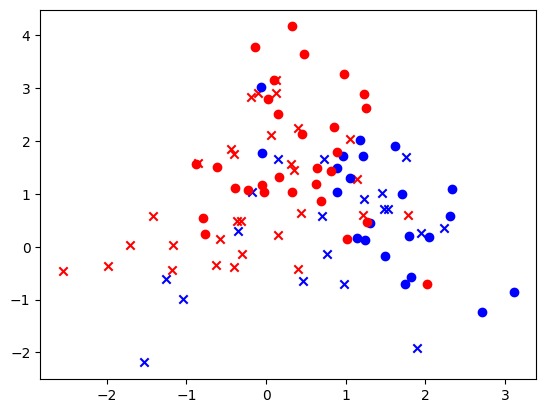

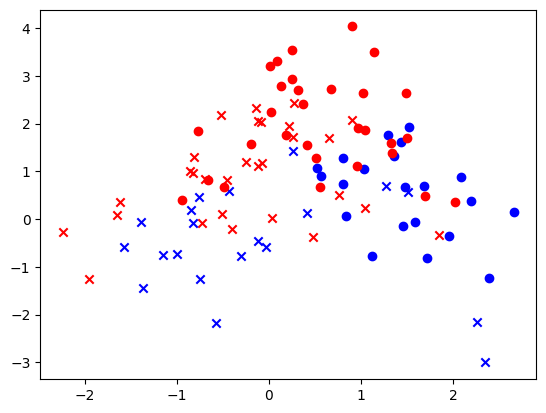

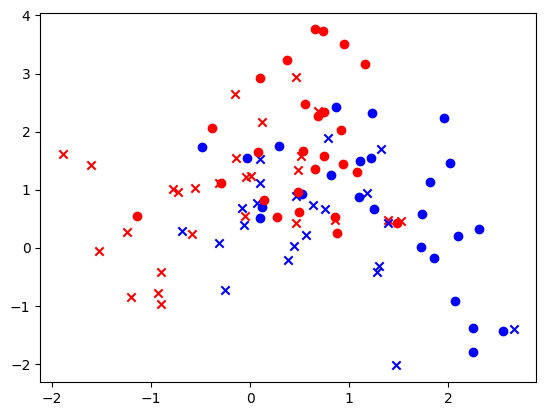

In [92]:
x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []
s_temp = np.array(s0)
for i in range(100):
    if y[i] == 1 and s_temp[i % 100] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % 100] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % 100] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_start = plt.figure()
ax = fig_start.gca()

ax.scatter(x00, z00, marker = 'x', color = 'red')
ax.scatter(x11, z11, marker = 'o', color = 'blue')
ax.scatter(x01, z01, marker = 'x', color = 'blue')
ax.scatter(x10, z10, marker = 'o', color = 'red')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(300, 400):
    if y[i] == 1 and s_temp[i % 100] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % 100] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % 100] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_3 = plt.figure()
ax3 = fig_3.gca()

ax3.scatter(x00, z00, marker = 'x', color = 'red')
ax3.scatter(x11, z11, marker = 'o', color = 'blue')
ax3.scatter(x01, z01, marker = 'x', color = 'blue')
ax3.scatter(x10, z10, marker = 'o', color = 'red')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(900, 1000):
    if y[i] == 1 and s_temp[i % 100] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % 100] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % 100] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x00, z00, marker = 'x', color = 'red')
axf.scatter(x11, z11, marker = 'o', color = 'blue')
axf.scatter(x01, z01, marker = 'x', color = 'blue')
axf.scatter(x10, z10, marker = 'o', color = 'red')


In [41]:

x = np.array(x, dtype=np.float32).reshape((100, seq_len, 2))
y = np.array(y, dtype=np.int32).reshape(100, seq_len, 1)
s0 = np.array(s0)
s_train, s_test, x_train, x_test, y_train, y_test = train_test_split(s0, x, y, test_size=test_size, random_state=10)
s_train, s_valid, x_train, x_valid, y_train, y_valid = train_test_split(s_train, x_train, y_train, test_size=valid_size, random_state=10)


In [70]:
class Generator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).scatter_(1, s0.long(), torch.ones_like(s0))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            s0 = torch.reshape(s0, (-1,))
            yt = torch.reshape(yt, (-1,))
            print(ss.shape)
            print(yt.shape)
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            xt = self.sigmoid(self.linear(output).squeeze())
            # xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round().detach()


class Discriminator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.rnn = nn.GRU(in_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, hn = self.rnn(x)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output


class DistributionDiscriminator(nn.Module):

    def __init__(self, hiddens):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.LeakyReLU(0.2))
        layers.pop()
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.model(x)
        return output

In [71]:
clf = Classifier(c_hiddens)
generator = Generator(x_dim, g_hidden_size, g_num_layers)
discriminator = Discriminator(x_dim, d_hidden_size, d_num_layers)

In [44]:
def train_discriminator(clf, G, D, optim, loss_fn, xs, zs, ss):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake.detach())
    loss_fake = loss_fn(fake, torch.zeros_like(fake))

    real = D(xs)
    loss_real = loss_fn(real, torch.ones_like(real))

    loss = loss_fake + loss_real

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss


def get_moment_loss(x_pred, x_true):
    m1 = torch.mean(torch.abs(x_pred.mean(dim=0) - x_true.mean(dim=0)))
    m2 = torch.mean(torch.abs(
        torch.sqrt(x_pred.var(dim=0, unbiased=False) + 1e-6) -
        torch.sqrt(x_true.var(dim=0, unbiased=False) + 1e-6)
    ))
    return m1 + m2


def train_generator(clf, G, D, optim, loss_fn, xs, zs, ss, gamma=100):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake)

    loss1 = loss_fn(fake, torch.ones_like(fake))
    loss2 = get_moment_loss(xs_fake, xs)
    loss = loss1 + gamma * loss2

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss


@count_time
def train_gan(loader, clf, G, D, n_epochs, device):
    g_optim = Adam(G.parameters())
    d_optim = Adam(D.parameters())
    loss_fn = nn.BCELoss()

    for epoch in range(n_epochs):
        
        for i, (s_mb, x_mb, y_mb) in enumerate(loader, start=1):
            batch, _, dim = x_mb.size()
            x_mb = x_mb.to(device)
            z_mb = torch.rand(batch, dim).to(device)

            for _ in range(2):
                g_loss = train_generator(clf, G, D, g_optim, loss_fn, x_mb, z_mb, s_mb)

            for _ in range(1):
                d_loss = train_discriminator(clf, G, D, d_optim, loss_fn, x_mb, z_mb, s_mb)

            step = epoch * len(loader) + i
            if step % 1000 == 0:
                print(f'Epoch: {epoch: 6.0f} | step: {step:6.0f} | d_loss: {d_loss:6.4f} | g_loss: {g_loss: 6.4f}')
            


def generate_dataset_from_gan(loader, clf, G, device, extra_seq=0):
    gen_s, gen_x, gen_y = [], [], []

    batch_size = None
    for s_mb, x_mb, y_mb in loader:
        batch, seq_len, x_dim = x_mb.shape
        if batch_size is None:
            batch_size = batch

        x_mb = x_mb.to(device)
        z_mb = torch.randn(batch, seq_len + extra_seq - 1, x_dim).to(device)

        gen_x_mb, _, gen_y_mb = G(x_mb[:, 0], z_mb, s_mb, clf)
        
        gen_s.append(s_mb)
        gen_x.append(gen_x_mb)
        gen_y.append(gen_y_mb)

    gen_s = torch.cat(gen_s, dim=0).detach().cpu().numpy()
    gen_x = torch.cat(gen_x, dim=0).detach().cpu().numpy()
    gen_y = torch.cat(gen_y, dim=0).detach().cpu().numpy()

    gen_data = TensorDataset(tensor(gen_s), tensor(gen_x), tensor(gen_y))
    gen_loader = DataLoader(gen_data, batch_size=batch_size, shuffle=False)

    return gen_loader, gen_s, gen_x, gen_y

In [72]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_data = TensorDataset(tensor(s_train), tensor(x_train), tensor(y_train))
valid_data = TensorDataset(tensor(s_valid), tensor(x_valid),tensor(y_valid))
test_data = TensorDataset(tensor(s_test), tensor(x_test), tensor(y_test))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
train_gan(train_loader, clf, generator, discriminator, gan_epochs, device)

torch.Size([10, 1])
torch.Size([10])


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

In [94]:
class Generator_test(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def h0_test(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).scatter_(1, s0.long(), torch.ones_like(s0))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        return h0

"""        
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            s0 = torch.reshape(s0, (-1,))
            yt = torch.reshape(yt, (-1,))
            print(ss.shape)
            print(yt.shape)
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            xt = self.sigmoid(self.linear(output).squeeze())
            # xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round().detach()
"""

'        \n        yt = clf(ss, x0)\n        \n        xs, ys = [x0], [yt]\n        for i in range(noise.size(1)):\n            s0 = torch.reshape(s0, (-1,))\n            yt = torch.reshape(yt, (-1,))\n            print(ss.shape)\n            print(yt.shape)\n            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)\n            output, h0 = self.rnn(y_noise, h0)\n            xt = self.sigmoid(self.linear(output).squeeze())\n            # xt = self.linear(output).squeeze()\n            yt = clf(ss, xt)\n\n            xs.append(xt)\n            ys.append(yt)\n\n        xs = torch.stack(xs, dim=1)\n        ys = torch.stack(ys, dim=1)\n        return xs, ys, ys.round().detach()\n'

In [95]:
G = Generator(x_dim, g_hidden_size, g_num_layers)
g_optim = Adam(G.parameters())
d_optim = Adam(D.parameters())
loss_fn = nn.BCELoss()

for i, (s_mb, x_mb, y_mb) in enumerate(train_loader, start=1):
    ss = torch.clone(s_mb)
    print(ss.shape)
    print(x_mb.shape)
    batch, _, dim = x_mb.size()
    x_mb = x_mb.to(device)
    z_mb = torch.rand(batch, dim).to(device)

    for _ in range(2):
        g_loss = train_generator(clf, G, D, g_optim, loss_fn, x_mb, z_mb, s_mb)


NameError: name 'G' is not defined